# Nuclear Spin Hamiltonian: Quadrupolar Basis

In [1]:
# Load "autoreload" extension so that code can change; set it so modules are reloaded before execution
%load_ext autoreload
%autoreload 2

In [2]:
import os.path as op

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import e as e_charge
from scipy.constants import hbar, mega
from scipy.optimize import fsolve
import sympy as sp
from sympy.physics.matrices import msigma

import nmrlib.core as nmr
import nmrlib.quantum as quant
from src import ROOT
from src.utils import find_max_min

import warnings

FIGSIZE = mpl.rcParams["figure.figsize"]

class Bunch(object):
    def __init__(self, adict):
        self.__dict__.update(adict)

In [3]:
sym = Bunch({})
Ix, Iy, Iz, Ip, Im = quant.get_spin_matrices(3/2)
sym.I = {}
sym.I['y'] = sp.Matrix([[0, -sp.I*sp.sqrt(3), 0, 0], [sp.I*sp.sqrt(3), 0, -sp.I*2, 0], [0, sp.I*2, 0, -sp.I*sp.sqrt(3)], [0, 0, sp.I*sp.sqrt(3), 0]])/2
sym.I['x'] = sp.Matrix([[0, sp.sqrt(3), 0, 0], [sp.sqrt(3), 0, 2, 0], [0, 2, 0, sp.sqrt(3)], [0, 0, sp.sqrt(3), 0]])/2
sym.I['z'] = sp.nsimplify(sp.Matrix(Iz), rational=True)
I = 3/2

In [4]:
sym.ap, sym.alpha, sym.delta, sym.D, sym.s = sp.symbols('a_+ alpha delta D s', real=True, positive=True)
sym.am = sp.symbols('a_-', real=True)
sym.S = sp.eye(4)
sym.X = [None]*4
sym.X[0] = sp.cos(sym.delta)*sym.S[:, 0] + sp.sin(sym.delta)*sym.S[:, 2]
sym.X[3] = sp.cos(sym.delta)*sym.S[:, 3] + sp.sin(sym.delta)*sym.S[:, 1]
sym.X[1] = sp.cos(sym.delta)*sym.S[:, 1] - sp.sin(sym.delta)*sym.S[:, 3]
sym.X[2] = sp.cos(sym.delta)*sym.S[:, 2] - sp.sin(sym.delta)*sym.S[:, 0]
mat1 = np.diag([1, -1, -1, 1])
mat2 = sp.Matrix(np.zeros([4, 4], dtype=object))
for i in range(4):
    for j in range(4):
        mat2[i, j] = sym.X[i].dot(sym.I['z']*sym.X[j])
subs1 = {2*sp.sin(sym.delta)**2: 1 - sp.cos(2*sym.delta), 2*sym.delta: sym.D}
subs2 = {sym.alpha + sp.cos(sym.D): sym.ap, sym.alpha - sp.cos(sym.D): sym.am, sp.sin(sym.D): sym.s}
mat2 = sp.simplify(mat2).subs(subs1)
sym.H = sp.simplify(sp.Matrix(sym.alpha*mat1 + mat2).subs(subs2))
sym.eig = sym.H.eigenvects()
sym.H

Matrix([
[a_+ + 1/2,          0,        -s,         0],
[        0, -a_- - 1/2,         0,         s],
[       -s,          0, 1/2 - a_+,         0],
[        0,          s,         0, a_- - 1/2]])

In [5]:
sym.E = [sym.eig[i][0] for i in range(4)]
sym.V = [None]*4
sym.V[0] = sym.eig[0][2][0]
sym.V[1] = sym.eig[1][2][0]*-sym.s/(sym.ap + sp.sqrt(sym.ap**2 + sym.s**2))
sym.V[2] = sym.eig[2][2][0]*-sym.s/(sym.am + sp.sqrt(sym.am**2 + sym.s**2))
sym.V[3] = sym.eig[3][2][0]*sym.s/(-sym.am + sp.sqrt(sym.am**2 + sym.s**2))*sym.s/(sym.am + sp.sqrt(sym.am**2 + sym.s**2))
_E, _V = ([None]*len(sym.V) for i in range(2))
sym.subs = {sym.ap: sym.alpha + sp.cos(sym.D), sym.am: sym.alpha - sp.cos(sym.D), sym.s: sp.sin(sym.D)}
for i in range(4):
    sym.E[i] = sym.E[i]
    sym.V[i] = sp.simplify(sym.V[i])#.subs(sym.subs).subs(sym.D, 0)
    display(sym.E[i], sym.V[i])
sym.E[2] = -sym.am*sp.sqrt(1 + (sym.s/sym.am)**2) - sp.Rational(1, 2)
sym.E[3] = sym.am*sp.sqrt(1 + (sym.s/sym.am)**2) - sp.Rational(1, 2)
sym.V[2] = sp.Matrix([0, 1, 0, -sym.s/(sym.am + sym.am*sp.sqrt(1 + (sym.s/sym.am)**2))])
sym.V[3] = sp.Matrix([0, sym.s/(sym.am + sym.am*sp.sqrt(1 + (sym.s/sym.am)**2)), 0, 1])

1/2 - sqrt(a_+**2 + s**2)

Matrix([
[s/(a_+ + sqrt(a_+**2 + s**2))],
[                            0],
[                            1],
[                            0]])

sqrt(a_+**2 + s**2) + 1/2

Matrix([
[                             1],
[                             0],
[-s/(a_+ + sqrt(a_+**2 + s**2))],
[                             0]])

-sqrt(a_-**2 + s**2) - 1/2

Matrix([
[                             0],
[                             1],
[                             0],
[-s/(a_- + sqrt(a_-**2 + s**2))]])

sqrt(a_-**2 + s**2) - 1/2

Matrix([
[                            0],
[s/(a_- + sqrt(a_-**2 + s**2))],
[                            0],
[                            1]])

In [6]:
for i in range(4):
    display(sym.E[i], sym.V[i])#.subs(sym.subs))#.subs(sym.D, 0))

1/2 - sqrt(a_+**2 + s**2)

Matrix([
[s/(a_+ + sqrt(a_+**2 + s**2))],
[                            0],
[                            1],
[                            0]])

sqrt(a_+**2 + s**2) + 1/2

Matrix([
[                             1],
[                             0],
[-s/(a_+ + sqrt(a_+**2 + s**2))],
[                             0]])

-a_-*sqrt(1 + s**2/a_-**2) - 1/2

Matrix([
[                                   0],
[                                   1],
[                                   0],
[-s/(a_-*sqrt(1 + s**2/a_-**2) + a_-)]])

a_-*sqrt(1 + s**2/a_-**2) - 1/2

Matrix([
[                                  0],
[s/(a_-*sqrt(1 + s**2/a_-**2) + a_-)],
[                                  0],
[                                  1]])

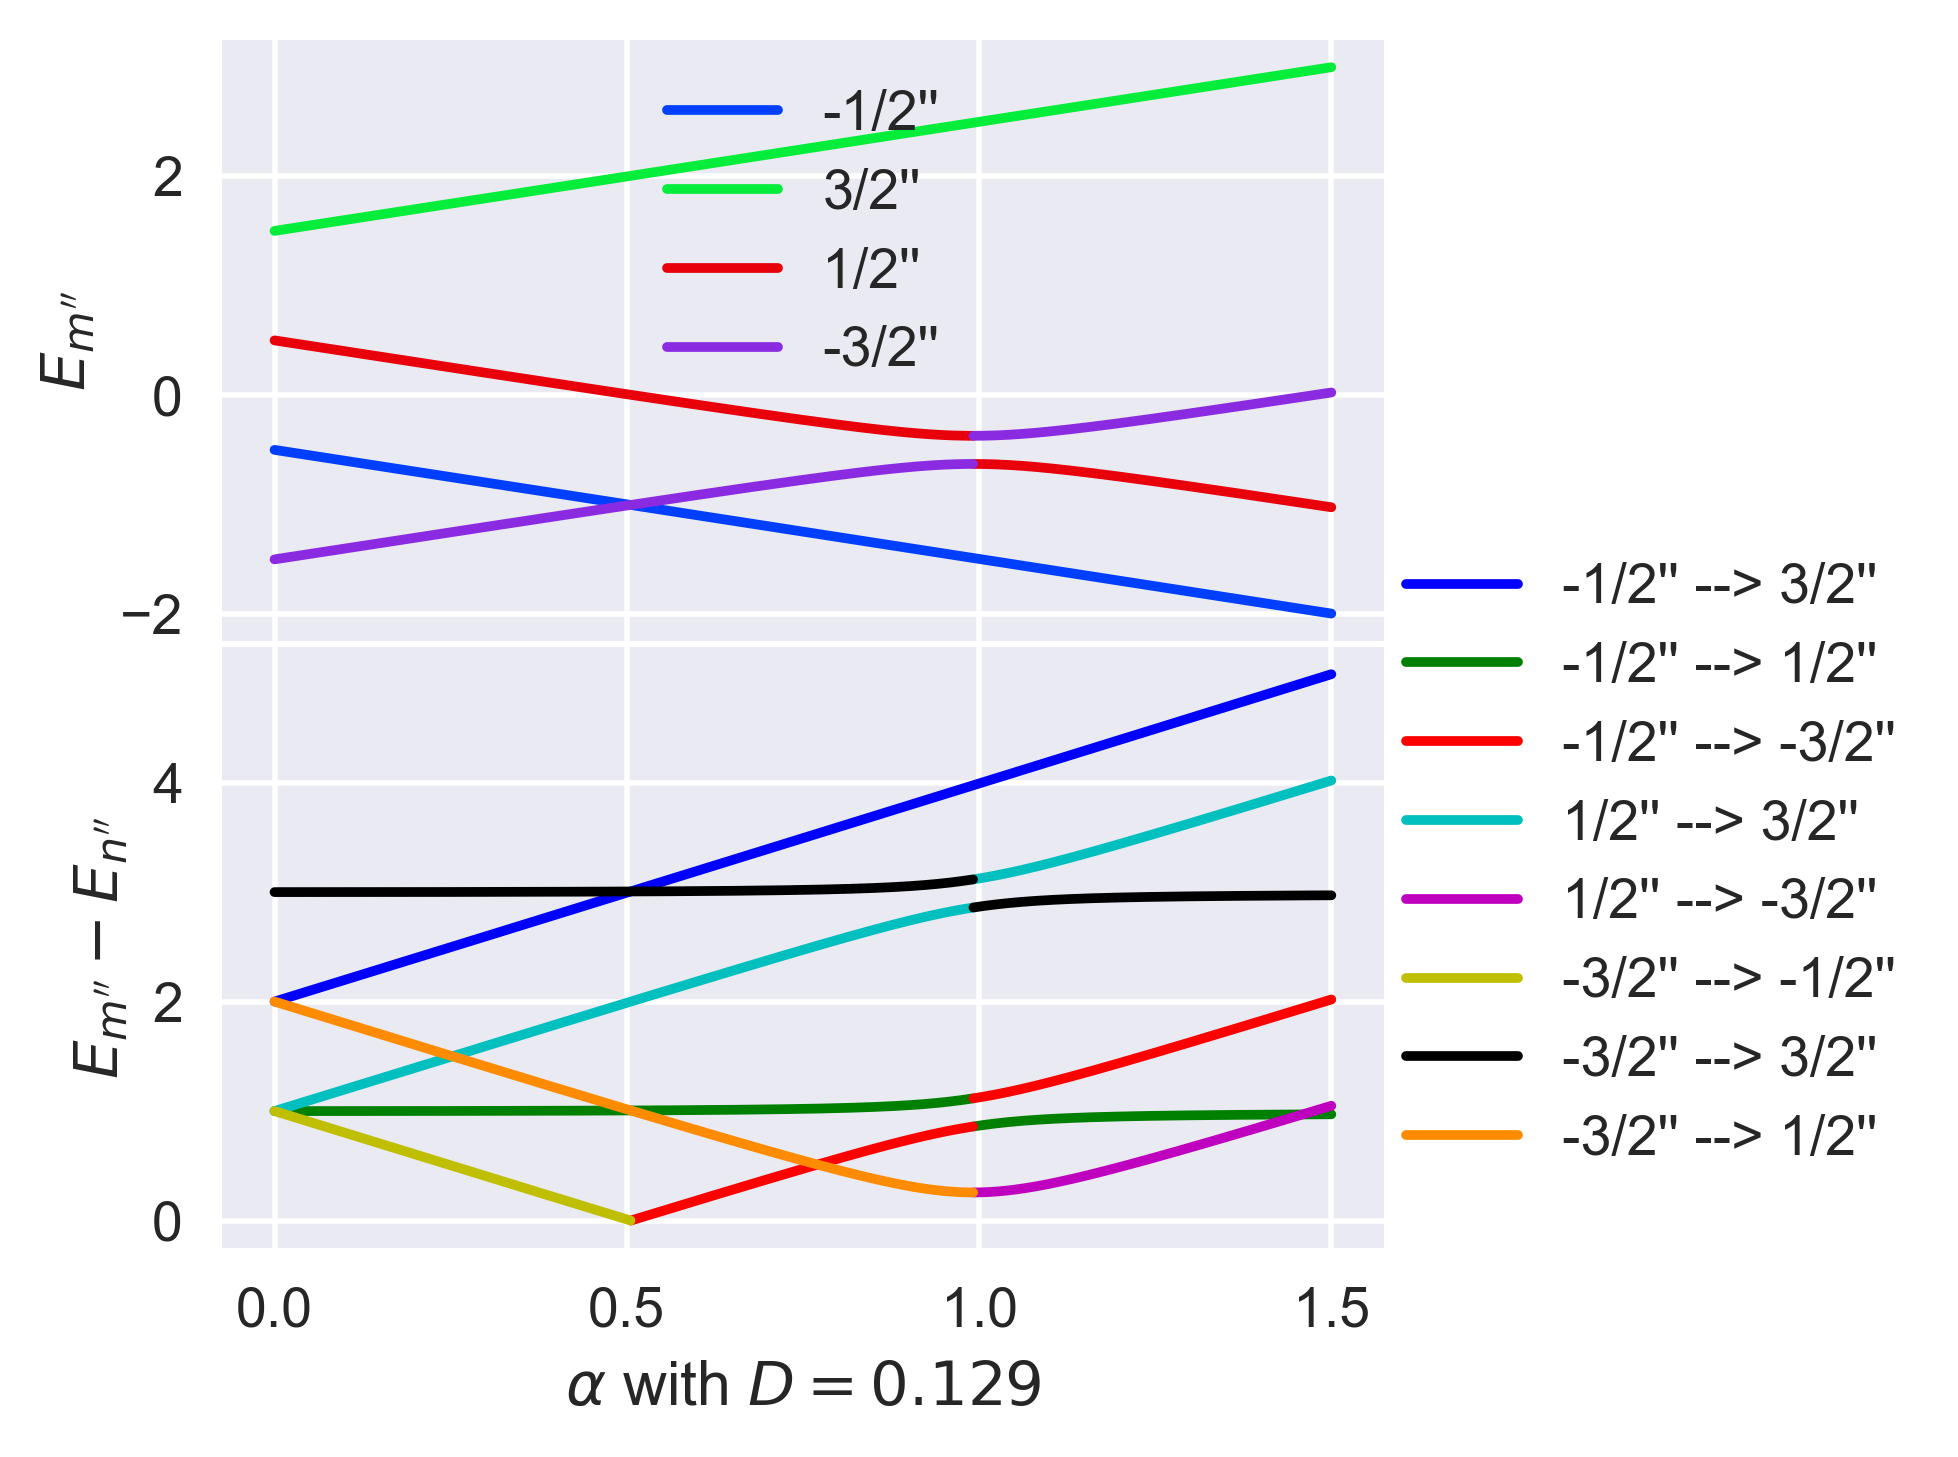

In [7]:
mpl.style.use('seaborn')
mpl.style.use('seaborn-bright')
alpha = np.linspace(0, 1.5, 5000)
D = np.arccos(0.9917172851021455)#np.pi/6/2/2#/10#np.sin(0)
num_subs = {sym.alpha: alpha, sym.D: D}
fig, ax = plt.subplots(2,
                       sharex=True,
                       dpi=400,
                       gridspec_kw={'hspace':0.01},
                       figsize=(FIGSIZE[0]/1.6, FIGSIZE[1]))
sym.EV = {}
sym.EV_norm = {}
for i in range(4):
    for j, e in enumerate(sym.V[i]):
        if e == 1:
            label = str(sp.nsimplify(np.arange(I, -I - 1, -1)[j]))
            sym.EV[label] = (sym.E[i], sym.V[i])
    E, V = sym.EV[label]
    norm = 1/sp.sqrt(V.dot(V))
    V_norm = sp.trigsimp(norm*V)
    sym.EV_norm[label] = (E, V_norm)
    y = sp.lambdify([sym.alpha, sym.D], E.subs(sym.subs))(alpha, D)
    y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
    ax[0].plot(alpha, y, label=f"{label}''")
sym.f = {}
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkorange', 'midnightblue', 'lawngreen', 'teal', 'thistle']
color_i = 0
for p in sym.EV:
    for q in sym.EV:
        Ep = sym.EV[p][0]
        Eq = sym.EV[q][0]
        f = Eq - Ep
        y = sp.lambdify([sym.alpha, sym.D], f.subs(sym.subs))(alpha, D)
        if type(y) == int and y == 0:
            pass
        else:
            x = alpha[y >= 0]
            y = y[y >= 0]
            if y.size > 0:
                sym.f[(p, q)] = f
                y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
                ax[1].plot(x, y, label=f"{p}'' --> {q}''", c=colors[color_i])
                color_i += 1
D_label = sp.nsimplify(D, constants=[sp.pi])
if D_label.p >= 100 or D_label.q >= 100:
    ax[1].set_xlabel(r'$\alpha$ with ' + fr'$D = {np.round(D, 3)}$')
else:
    ax[1].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(D_label, fold_short_frac=True)}$');
ax[1].set_ylabel(r"$E_{m''} - E_{n''}$")
ax[0].set_ylabel(r"$E_{m''}$")
ax[0].legend()
ax[1].legend(loc=(1, 0.1))
#fig.savefig(op.join(ROOT, 'reports', 'nuclear_hamiltonian', 'energy_trans.jpg'), bbox_inches='tight')

In [8]:
# mat = sp.Matrix(np.zeros((4, 5)))
# cob = sp.Matrix(np.column_stack([sym.X[i] for i in range(4)]))
# subs = {sp.cos(sym.delta): sp.sqrt(1 - sp.sin(sym.delta)**2), sym.s: sp.sin(sym.D)}
# for i, t in enumerate(sym.EV):
#     for j in range(4):
#         mat[:, j] = sym.X[j]
#     mat[:, 4] = sym.EV[t][1]
#     coord = sp.simplify((mat.rref()[0][:, -1]))#.subs(sym.subs))
#     check = ([coord[k]*sym.X[k] for k in range(4)])
#     comb = check[0] + check[1] + check[2] + check[3]
#     comb = sp.simplify(comb)
#     vec = (sp.simplify(cob*coord))#.subs(sym.subs))
#     print(t)
#     display(vec, sp.trigsimp(coord.subs(subs)))#mat.rref()[0])

In [9]:
sym.eps = sp.symbols('varepsilon', real=True)
def gij(i, j):
#     g = (sym.alpha + i*sp.cos(sym.D))\
#         *sp.sqrt(1 + (sp.sin(sym.D)/(sym.alpha + i*sp.cos(sym.D)))**2)\
#         + sym.alpha + j
    g = sym.eps + sym.alpha + j
    
    return g

Matrix([
[alpha*cos(2*delta) + 3/2,                         0,        alpha*sin(2*delta),                        0],
[                       0, -alpha*cos(2*delta) + 1/2,                         0,       alpha*sin(2*delta)],
[      alpha*sin(2*delta),                         0, -alpha*cos(2*delta) - 1/2,                        0],
[                       0,        alpha*sin(2*delta),                         0, alpha*cos(2*delta) - 3/2]])

3/2 --> 3/2


0

1/2 --> 3/2


-2*alpha + g_{+} + g_{-} + 1

-1/2 --> 3/2


-2*alpha + 2*g_{+}

-3/2 --> 3/2


g_{+} - g_{-} + 1

3/2 --> 1/2


2*alpha - g_{+} - g_{-} - 1

1/2 --> 1/2


0

-1/2 --> 1/2


g_{+} - g_{-} - 1

-3/2 --> 1/2


2*alpha - 2*g_{-}

3/2 --> -1/2


2*alpha - 2*g_{+}

1/2 --> -1/2


-g_{+} + g_{-} + 1

-1/2 --> -1/2


0

-3/2 --> -1/2


2*alpha - g_{+} - g_{-} + 1

3/2 --> -3/2


-g_{+} + g_{-} - 1

1/2 --> -3/2


-2*alpha + 2*g_{-}

-1/2 --> -3/2


-2*alpha + g_{+} + g_{-} - 1

-3/2 --> -3/2


0

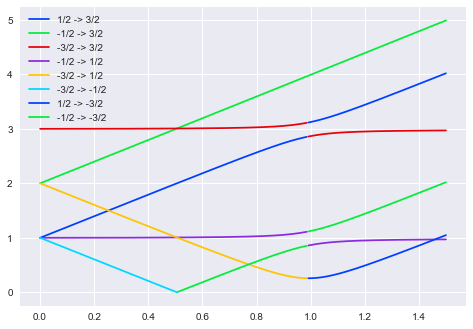

In [10]:
sym.gp, sym.gm, sym.Ap, sym.Am = sp.symbols('g_{+} g_{-} A_{+} A_{-}', real=True)

def gj(j):
    #return sym.alpha + sp.sqrt((sym.alpha + j*sp.cos(sym.D))**2 + sp.sin(sym.D)**2)
    return sym.alpha + sp.sign(sym.alpha + j*sp.cos(sym.D))*sp.sqrt((sym.alpha + j*sp.cos(sym.D))**2 + sp.sin(sym.D)**2)

def sym_gj(j):
    return {+1: sym.gp, -1: sym.gm}[j]
    
def Aj(j):
    #return 1/((sym_gj(j) + j*sp.cos(sym.D))*sp.sqrt(1 + (sp.sin(sym.D)/(sym_gj(j) + j*sp.cos(sym.D)))**2))
    #return 1/sp.sqrt((sym_gj(j) + j*sp.cos(sym.D))**2 + sp.sin(sym.D)**2)
    return sp.sign(sym_gj(j) + j*sp.cos(sym.D))/sp.sqrt((sym_gj(j) + j*sp.cos(sym.D))**2 + sp.sin(sym.D)**2)

def sym_Aj(j):
    return {1: sym.Ap, -1: sym.Am}[j]

gsubs = {sym.gp: gj(+1), sym.gm: gj(-1)}
Asubs = {sym.Ap: Aj(1), sym.Am: Aj(-1)}
dsubs = {sym.D: 2*sym.delta}

U = sp.zeros(4, 4)
for k in range(4):
    bk = sym.S[:, k]
    ak = sym.X[k]
    U += bk*ak.T

sym.Epp = {}
sym.Xpp = {}
sym.Xpp['3/2'] = ((sym.gp + 1)*sp.cos(sym.delta)*sym.S[:, 0] + (sym.gp - 1)*sp.sin(sym.delta)*sym.S[:, 2])*sym.Ap
sym.Xpp['-3/2'] = ((sym.gm - 1)*sp.cos(sym.delta)*sym.S[:, 3] + (sym.gm + 1)*sp.sin(sym.delta)*sym.S[:, 1])*sym.Am
sym.Xpp['1/2'] = ((sym.gm - 1)*sp.cos(sym.delta)*sym.S[:, 1] - (sym.gm + 1)*sp.sin(sym.delta)*sym.S[:, 3])*sym.Am
sym.Xpp['-1/2'] = ((sym.gp + 1)*sp.cos(sym.delta)*sym.S[:, 2] - (sym.gp - 1)*sp.sin(sym.delta)*sym.S[:, 0])*sym.Ap
sym.Epp['3/2'] = sym.gp - sym.alpha + sp.Rational(1, 2)
sym.Epp['-3/2'] = sym.gm - sym.alpha - sp.Rational(1, 2)
sym.Epp['1/2'] = -(sym.gm - sym.alpha + sp.Rational(1, 2))
sym.Epp['-1/2'] = -(sym.gp - sym.alpha - sp.Rational(1, 2))

delta = np.linspace(0, np.pi/12)
alpha = np.linspace(0, 1.5, 500)#[np.linspace(0, 1.5) != 1]
H = sp.simplify(U.T*(sym.H.subs(sym.subs))*U).subs(dsubs)
display(H)
Hlam = sp.lambdify([sym.alpha, sym.delta], H)
for i, m in enumerate(['3/2', '1/2', '-1/2', '-3/2']):
    Xlam = sp.lambdify([sym.alpha, sym.delta], sym.Xpp[m].subs(Asubs).subs(gsubs).subs(dsubs))
    Elam = sp.lambdify([sym.alpha, sym.delta], sym.Epp[m].subs(Asubs).subs(gsubs).subs(dsubs))
    for a in alpha:
        for d in delta:
            Hf = Hlam(a, d)
            Xf = np.squeeze(Xlam(a, d))
            Ef = Elam(a, d)
            _En, _Xn = np.linalg.eig(Hf)
            index = np.array([0, 1, 2, 3])[np.isclose(Ef, _En)][0]
            En, Xn = _En[index], _Xn[:, index]
            Ediff = np.isclose(En - Ef, 0)
            Xdiff1 = np.all(np.isclose(Xn - Xf, 0))
            Xdiff2 = np.all(np.isclose(Xn + Xf, 0))
            if Ediff == False or (Xdiff1 == False and Xdiff2 == False) or np.any(np.isnan(Xn)) or np.any(np.isnan(Xf)):
                print(m, a, d)
                print(Ef, En)
                print(Xf)
                print(Xn)
                print('='*80)

delta = 0.129/2
alpha = np.linspace(0, 1.5, 500)#[np.linspace(0, 1.5) != 1]
for i, m in enumerate(['3/2', '1/2', '-1/2', '-3/2']):
    for j, mp in enumerate(['3/2', '1/2', '-1/2', '-3/2']):
        E = sym.Epp[m]
        Ep = sym.Epp[mp]
        print(f'{mp} --> {m}')
        display(E - Ep)
        print('='*80)
        E = sym.Epp[m].subs(gsubs).subs(dsubs)
        Ep = sym.Epp[mp].subs(gsubs).subs(dsubs)
        f = sp.lambdify([sym.alpha, sym.delta], E - Ep)(alpha, delta)
        if E - Ep != 0:
            x = alpha[f >= 0]
            f = f[f >= 0]
            if len(f) != 0:
                f[:-1][np.abs(np.diff(f)) > 0.1] = np.nan
                plt.plot(x, f, label=f"{mp} -> {m}")
plt.legend()

In [11]:
sym.w1, sym.w2, sym.wi = sp.symbols('omega_1 omega_2 omega_i', real=True, positive=True)
p1, p2, p3, p4, p5, p6, p7, p8 = sp.symbols(r'p_1 p_2 p_3 p_4 p_5 p_6 p_7 p_8', real=True)
gsubs = {sym.gp: gj(+1), sym.gm: gj(-1)}
dsubs = {sym.D: 2*sym.delta}
f1 =  sym.wi*(p1 + p2*sym.alpha + p3*sym.gp + p4*sym.gm)
f2 =  sym.wi*(p5 + p6*sym.alpha + p7*sym.gp + p8*sym.gm)
# subs = {sym.am*sp.sqrt(1 + sym.s**2/sym.am**2): sym.x, sp.sqrt(sym.ap**2 + sym.s**2): sym.y}
exp1 = f1 - sym.w1
exp2 = f2 - sym.w2
gsol = list(sp.nonlinsolve([exp1, exp2], [sym.gp, sym.gm]))[0]
gsol
# exp1 = gj(1)**2 - gsol[0]**2
# exp2 = gj(-1)**2 - gsol[1]**2
# psol = (sp.nonlinsolve([exp1, exp2], [sym.alpha, sp.cos(sym.D)]))
# psol

(-(alpha*omega_i*p_2*p_8 - alpha*omega_i*p_4*p_6 - omega_1*p_8 + omega_2*p_4 + omega_i*p_1*p_8 - omega_i*p_4*p_5)/(omega_i*(p_3*p_8 - p_4*p_7)), (alpha*omega_i*p_2*p_7 - alpha*omega_i*p_3*p_6 - omega_1*p_7 + omega_2*p_3 + omega_i*p_1*p_7 - omega_i*p_3*p_5)/(omega_i*(p_3*p_8 - p_4*p_7)))

In [12]:
sp.solve([gj(1) - sp.symbols('c')], [sym.alpha])

NotImplementedError: could not solve alpha - c + sqrt((alpha + cos(D))**2 + sin(D)**2)*sign(alpha + cos(D))

In [ ]:
pm1 = [-1, -1, -1]
pm2 = [-1, -1, 1]
alpha = .2
delta = np.linspace(0, np.pi/12)
#q = sp.lambdify([sym.alpha, sym.delta], (Aj(pm[0])*(gj(pm[1]) + pm[2])*sp.cos(sym.delta)).subs(gsubs).subs(dsubs))
q1 = sp.lambdify([sym.alpha, sym.delta], (Aj(pm1[0])*(gj(pm1[1]) + pm1[2])).subs(gsubs).subs(dsubs))
q2 = sp.lambdify([sym.alpha, sym.delta], (Aj(pm2[0])*(gj(pm2[1]) + pm2[2])).subs(gsubs).subs(dsubs))
q3 = sp.lambdify([sym.alpha, sym.delta], (gj(-1) - 1).subs(gsubs).subs(dsubs))(alpha, delta)
q4 = sp.lambdify([sym.alpha, sym.delta], (gj(1) - 1).subs(gsubs).subs(dsubs))(alpha, delta)
#plt.plot(delta, q1(alpha, delta), label='cos')
#plt.plot(delta, q2(alpha, delta), label='sin')
plt.plot(delta, q3, label='g')
plt.legend()
#print(np.arccosh(q3))
#print(np.arcsinh(q4))

In [ ]:
betax = sp.zeros(4, 4)
betay = sp.zeros(4, 4)
betaz = sp.zeros(4, 4)
for i, m in enumerate(['3/2', '1/2', '-1/2', '-3/2']):
    for j, mp in enumerate(['3/2', '1/2', '-1/2', '-3/2']):
        X = sym.Xpp[m].subs(Asubs).subs(gsubs)
        Xp = sym.Xpp[mp].subs(Asubs).subs(gsubs)
        betax[i, j] = sp.simplify(sp.trigsimp(X.T*sym.I['x']*Xp))
        #betay[i, j] = sp.simplify(sp.trigsimp(X.T*sym.I['y']*Xp))
        #betaz[i, j] = sp.simplify(sp.trigsimp(X.T*sym.I['z']*Xp))
display(sp.simplify(betax))

In [ ]:
# sym.Ep, sym.Em, sym.gpp, sym.gpm, sym.gmp, sym.gmm = sp.symbols('E_{+} E_{-} g_{++} g_{+-} g_{-+} g_{--}', real=True)
# subs = {sym.EV['3/2'][0] - sp.Rational(1, 2): sym.Ep,
#         sym.EV['-3/2'][0] + sp.Rational(1, 2): sym.Em}
# subs2 = [(sym.Ep + sym.alpha + 1, sym.gpp),
#          (2 - sym.gpp, -sym.gpm),
#          (sym.Em + sym.alpha - 1, sym.gmm),
#          (sym.gmm + 2, sym.gmp)]
# subs.update(sym.subs)
# gsubs = {sym.gpp: gij(1, 1),
#           sym.gpm: gij(1, -1),
#           sym.gmp: gij(-1, 1),
#           sym.gmm: gij(-1, -1)}
# U = sp.zeros(4, 4)
# for k in range(4):
#     _bk = sp.Matrix([0, 0, 0, 0])
#     _bk[k] = 1
#     bk = _bk
#     ak = sym.X[k]
#     U += bk*ak.T
# sym.V_mbasis = {}
# Hp = sp.simplify(U.T*(sym.H.subs(sym.subs))*U).subs(sym.D, 2*sym.delta)
# jkjl = {'3/2': (1, 1, 1, -1),
#         '1/2': (-1, -1, -1, 1),
#         '-1/2': (1, -1, 1, 1),
#         '-3/2': (-1, 1, -1, -1)}
# c = {'3/2': 1,
#      '1/2': -1,
#      '-1/2': 1,
#      '-3/2': -1}
# fig, ax = plt.subplots(4)
# for i, m in enumerate(sym.EV):
#     E = sym.EV[m][0].subs(sym.subs)
#     _V = (U.T*sym.EV[m][1]).subs(subs).subs(sym.D, 2*sym.delta)
#     if _V[0] == 0:
#         factor = (sym.Em + sym.alpha - sp.cos(2*sym.delta))#/sp.cos(sym.delta)
#         eps = sp.sqrt((sym.alpha - sp.cos(sym.D))**2 + sp.sin(sym.D)**2)
#         #eps = (sym.EV['-3/2'][0] + sp.Rational(1, 2)).subs(sym.subs).subs(sym.D, 2*sym.delta)
#     else:
#         factor = (sym.Ep + sym.alpha + sp.cos(2*sym.delta))#/sp.cos(sym.delta)
#         eps = sp.sqrt((sym.alpha + sp.cos(sym.D))**2 + sp.sin(sym.D)**2)
#         #eps = (sym.EV['3/2'][0] - sp.Rational(1, 2)).subs(sym.subs).subs(sym.D, 2*sym.delta)
#     _V = sp.simplify(_V*factor).subs(subs).subs(subs2)
#     term = sym.alpha + sp.sqrt((sym.alpha + jkjl[m][0]*sp.cos(sym.D))**2 + sp.sin(sym.D)**2) + c[m]*sp.cos(sym.D)
#     V = (_V.subs(gsubs).subs(sym.eps, eps)/\
#         (term*sp.sqrt(1 + (sp.sin(sym.D)/term)**2))).subs(sym.D, 2*sym.delta)#.subs(sym.alpha, 0.001).subs(sym.delta, 0.01)
#         #term*sp.sqrt(1 + (sp.sin(sym.D)/term)**2) + sp.sin(sym.D)**2).subs(sym.D, 2*sym.delta)
# #         sp.sqrt(
# #          (sym.alpha
# #           + sp.sqrt((sym.alpha + jkkl[m][0]*sp.cos(sym.D))**2 + sp.sin(sym.D)**2)
# #           + c[m]*sp.cos(sym.D))**2
# #          + sp.sin(sym.D)**2)).subs(sym.D, 2*sym.delta)
# #         sp.sqrt((sym.alpha
# #          + (sym.alpha + jkjl[m][0]*sp.cos(sym.D))*sp.sqrt(1 + (sp.sin(sym.D)/(sym.alpha + jkkl[m][0]*sp.cos(sym.D)))**2)
# #          + c[m]*sp.cos(sym.D))**2 + sp.sin(sym.D)**2)).subs(sym.D, 2*sym.delta)
#     #norm = sp.simplify(1/sp.sqrt(_V.dot(_V))).subs(gsubs).subs(sym.eps, eps)
#     #V = sp.trigsimp(_V*norm)
#     #sym.V_mbasis[m] = (_V, sp.trigsimp(norm))
#     display(V)#.subs(sym.delta, 0))
#     norm = sp.lambdify([sym.alpha, sym.delta], V.dot(V))
#     alpha = np.linspace(0, np.pi/12)
#     ax[i].plot(alpha, norm(1.1, alpha))
#     #display(m, sp.simplify(sp.trigsimp(V.dot(V))))#.subs({sym.alpha: 1.2, sym.delta: 0.2}))
# #    _V = _V.subs(gsubs)
# #     E = (E.subs(sym.D, 2*sym.delta)).subs(eps, sym.eps)
# #     v = sp.simplify((Hp*_V - E*_V).subs(sym.eps, eps))
# #     display(v)
#     print('='*80)

In [ ]:
sym.sigma1, sym.sigma2, sym.sigma3, sym.t = sp.symbols('sigma_1 sigma_2 sigma_3 t')
sym.sigma = sp.Matrix([sym.sigma1, sym.sigma2, sym.sigma3])
sigma_subs = {sym.sigma1: msigma(1), sym.sigma2: msigma(2), sym.sigma3: msigma(3)}
sym.Iexp = {}
sym.Iexp['x'] = {}
sym.Iexp['y'] = {}
sym.Iexp['z'] = {}
V10 = sp.Matrix([1, 0])
V01 = sp.Matrix([0, 1])
c = [None]*3
c[0] = sp.Matrix([1, 0, 0]).dot([1, 0, 0])
c[1] = sp.Matrix([1, 0, 0]).dot([0, 1, 0])
c[2] = sp.Matrix([1, 0, 0]).dot([0, 0, 1])
beta = {}
beta['x'] = sp.Matrix(np.zeros((4, 4)))
beta['y'] = sp.Matrix(np.zeros((4, 4)))
beta['z'] = sp.Matrix(np.zeros((4, 4)))
for xyz in ['x', 'y', 'z']:
    for i, p in enumerate(sym.V_mbasis):
        for j, q in enumerate(sym.V_mbasis):
            Ep, Eq = sym.EV[p][0], sym.EV[q][0]
            (Vp, normp), (Vq, normq) = sym.V_mbasis[p], sym.V_mbasis[q]
            wpq = Eq - Ep
            norm = sp.simplify(normp*normq)
            beta[xyz][i, j] = 4*Vp.dot(sym.I[xyz]*Vq)
for i, p in enumerate(sym.V_mbasis):
    for j, q in enumerate(sym.V_mbasis):
        compi, compj = 0, 0
        for m, xyz in enumerate(['x', 'y', 'z']):
            betam = beta[xyz][i, j]
            compi += c[m]*sp.re(betam)
            compj += c[m]*sp.im(betam)
        norm = sp.sqrt(compi**2 + compj**2)
        if norm != 0:
            nhat = sp.Matrix([compi, compj, 0])/norm
            mid = (nhat.cross(sym.sigma)[2]).subs(sigma_subs)
            factor = sp.simplify((V01.T*mid*V10)[0])
            display(factor)
    #_Iexp = wpq*((V01.T*Vmid).dot(V10))*beta/(2*(2*I + 1))*sp.exp(sp.I*wpq*sym.t)
    #Iexp = _Iexp# + sp.conjugate(_Iexp)
#display(sp.simplify(beta))#, norm)
            #print('='*80)

#             sym.Iexp[xyz][(p, q)] = sp.lambdify([sym.alpha, sym.D, sym.t], Iexp.subs(sym.subs).subs(sym.delta, sym.D/2))

In [ ]:
# Warning: this cell takes about 1-2 minutes to run
sym.sigma1, sym.sigma2, sym.sigma3, sym.t = sp.symbols('sigma_1 sigma_2 sigma_3 t')
sym.sigma = sp.Matrix([sym.sigma1, sym.sigma2, sym.sigma3])
sigma_subs = {sym.sigma1: msigma(1), sym.sigma2: msigma(2), sym.sigma3: msigma(3)}
sym.Iexp = {}
sym.Iexp['x'] = {}
sym.Iexp['y'] = {}
sym.Iexp['z'] = {}
V10 = sp.Matrix([1, 0])
V01 = sp.Matrix([0, 1])
c = [None]*3
c[0] = sp.Matrix([1, 0, 0]).dot([1, 0, 0])
c[1] = sp.Matrix([1, 0, 0]).dot([0, 1, 0])
c[2] = sp.Matrix([1, 0, 0]).dot([0, 0, 1])
for xyz in ['x', 'y', 'z']:
    for p in sym.V_mbasis:
        for q in sym.V_mbasis:
            Ep, Eq = sym.EV[p][0], sym.EV[q][0]
            Vp, Vq = sym.V_mbasis[p], sym.V_mbasis[q]
            wpq = Eq - Ep
            beta = Vp.dot(sym.I[xyz]*Vq)
            compi, compj = 0, 0
            for m, xyz2 in enumerate(['x', 'y', 'z']):
                betam = Vp.dot(sym.I[xyz2]*Vq)
                compi += c[m]*sp.re(betam)
                compj += c[m]*sp.im(betam)
            nhat = (sp.Matrix([compi, compj, 0])/sp.sqrt(compi**2 + compj**2))
            Vmid = (nhat.cross(sym.sigma)[2]).subs(sigma_subs)
            _Iexp = wpq*((V01.T*Vmid).dot(V10))*beta/(2*(2*I + 1))*sp.exp(sp.I*wpq*sym.t)
            Iexp = _Iexp# + sp.conjugate(_Iexp)
            sym.Iexp[xyz][(p, q)] = sp.lambdify([sym.alpha, sym.D, sym.t], Iexp.subs(sym.subs).subs(sym.delta, sym.D/2))

In [ ]:
# # Run above cell before running this one if it has been a while...
# mpl.style.use('seaborn')
# alpha = np.linspace(0, 1.5, 5000)[1:]
# D = np.pi/24#/10#np.sin(0)
# fig, ax = [None]*3, [None]*3
# fig[0], ax[0] = plt.subplots(1, dpi=150)
# fig[1], ax[1] = plt.subplots(1, dpi=150)
# fig[2], ax[2] = plt.subplots(1, dpi=150)
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkorange']
# color_i = 0
# for i, xyz in enumerate(['x', 'y', 'z']):
#     Iexp = sym.Iexp[xyz]
#     for j, tran in enumerate(Iexp):
#         p, q = tran
#         y = Iexp[tran](alpha, D)# + np.conjugate(Iexp[tran](alpha, D))
#         #print(y, type(y))
#         cond = type(y) == int and y == 0\
#                or type(y) == float\
#                or type(y) == np.float64 or np.all(np.isclose(y, np.zeros(alpha.size)))
#         if cond:
#             pass
#         else:
#             y[:-1][np.abs(np.diff(y)) > 0.01] = np.nan
#             ax[i].plot(alpha, np.real(y), label=f"{p}'' --> {q}''", color=colors[color_i])
#             color_i += 1
#     ax[i].set_ylabel(r'$\langle I_' + xyz + r'\rangle$ $(\hbar/kT)$')
#     ax[i].legend()
#     ax[i].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(sp.nsimplify(D, constants=[sp.pi]), fold_short_frac=True)}$');

In [ ]:
alpha = np.linspace(0, 1.5, 5000)[1:]
D = np.arccos(0.9917172851021455)#np.pi/6
xdata = {}
ydata = {}
cdata = {}
xyz_data_labels = []
for i, xyz in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[xyz]
    xdata[xyz] = {}
    ydata[xyz] = {}
    cdata[xyz] = {}
    for j, t in enumerate(Iexp):
        p, q = t
        Ep, Eq = sym.EV[p][0], sym.EV[q][0]
        f = sp.lambdify([sym.alpha, sym.D], (Eq - Ep).subs(sym.subs))
        y = f(alpha, D)
        c = Iexp[t](alpha, D, 0)
        if not np.all(np.isclose(np.imag(c), np.zeros(alpha.size))):
            pass#c = np.imag(c)
        else:
            c = np.real(c)
        cond = type(y) == int and y == 0\
               or type(c) == int and c == 0\
               or type(c) == float\
               or np.all(np.isclose(c, np.zeros(alpha.size)))
        if cond:
            pass
        else:
            x = alpha[y >= 0]
            c = c[y >= 0]
            y = y[y >= 0]
            if y.size == 0:
                pass
            else:
                y[:-1][np.abs(np.diff(y)) > 0.01] = np.nan
                xdata[xyz][t] = x
                ydata[xyz][t] = y
                cdata[xyz][t] = c
    if list(cdata[xyz].values()) != []:
        xyz_data_labels.append(xyz)

mpl.style.use('default')
fig, ax = plt.subplots(len(xyz_data_labels),
                       sharex=True,
                       gridspec_kw = {'hspace': 0.05},
                       figsize=(FIGSIZE[0]/1.5, FIGSIZE[1]),
                       dpi=450)
cmin, cmax = 100, 0
for i, xyz in enumerate(xyz_data_labels):
    cdata_list = list(cdata[xyz].values())
    ydata_list = list(ydata[xyz].values())
    if len(cdata_list) > 0:
        _cmax, _cmin = find_max_min([np.abs(c) for c in cdata_list])
        if _cmax > cmax:
            cmax = _cmax
        if _cmin < cmin:
            cmin = _cmin
for i, xyz in enumerate(xyz_data_labels):
    cdata_list = list(cdata[xyz].values())
    ydata_list = list(ydata[xyz].values())
    if len(cdata_list) > 0:
        ymax, ymin = find_max_min(ydata_list)
        norm = plt.Normalize(cmin, cmax)
        for j, t in enumerate(cdata[xyz]):
            x = xdata[xyz][t]
            y = ydata[xyz][t]
            c = np.abs(cdata[xyz][t])/cmax/y
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = mpl.collections.LineCollection(segments, cmap='hot', norm=norm)
            lc.set_array(c)
            lc.set_linewidth(2)
            line = ax[i].add_collection(lc)
        ax[i].set_xlim(alpha.min(), alpha.max())
        ax[i].set_ylim(ymin, ymax)
        D_label = sp.nsimplify(D, constants=[sp.pi])
        ax[i].set_ylabel(r"$ E_{m''} - E_{n''}$")
        ax[i].set_facecolor("black")
        ax[i].text(0.1, 0.9,
                   r"$i = " + xyz + "$",
                   color='w',
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax[i].transAxes)
if D_label.p >= 100 or D_label.q >= 100:
    ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {np.round(D, 3)}$')
else:
    ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(D_label, fold_short_frac=True)}$');
cbar = fig.colorbar(line, ax=ax[0:], location='right')#, shrink=0.6)
cbar.set_label(r"$\langle I_i \rangle/(E_{m''} - E_{n''})$")
#fig.savefig(op.join(ROOT, 'reports', 'nuclear_hamiltonian', 'magmom.jpg'), bbox_inches='tight')

In [ ]:
alpha = 100
D = 0.01
fig, ax = plt.subplots(3,
                       sharex=True,
                       gridspec_kw = {'hspace': 0.05},
                       figsize=(FIGSIZE[0]/1.5, FIGSIZE[1]),
                       dpi=200)
data = {}
for i, xyz in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[xyz]
    data[xyz] = {}
    for j, tran in enumerate(Iexp):
        p, q = tran
        Ep, Eq = sym.EV[p][0], sym.EV[q][0]
        w = sp.lambdify([sym.alpha, sym.D], (Eq - Ep).subs(sym.subs))(alpha, D)
        cond1 = w != 0 and w > 0
        if cond1:
            t = np.linspace(0, 2*np.pi)/w
            y = Iexp[tran](alpha, D, t)
            cond2 = (type(y) == float and np.isnan(y)) or (type(y) == int)
            if cond2:
                pass
            else:
                data[xyz][tran] = (y, w, t)
                #p = ax[i].plot(t*wpq, np.real(y))
                #ax[i].plot(t*wpq, np.imag(y), '.', c=p[-1].get_color())
for i, tran in enumerate(data['x']):
    Ix, wx, tx = data['x'][tran]
    Iy, wy, ty = data['y'][tran]
    Itot = Ix*np.cos(wx*tx) + Iy*np.sin(wy*ty)
    px = ax[0].plot(tx*wx, np.real(Ix))
    py = ax[1].plot(ty*wy, np.real(Iy))
    ptot = ax[2].plot(tx*wx, np.real(Itot))
    ax[0].plot(tx*wx, np.imag(Ix), '-.', c=px[-1].get_color())        
    ax[1].plot(ty*wy, np.imag(Iy), '-.', c=py[-1].get_color())
    ax[2].plot(tx*wx, np.imag(Itot), '-.', c=ptot[-1].get_color())
    
ax[-1].set_xlabel(r'$ \omega t $')
ax[0].set_ylabel(r'$ I_x $')
ax[1].set_ylabel(r'$ I_y $')

# Parameters

In [ ]:
for t in sym.f:
    print(t)
    display(sym.f[t])
    print('='*80)

In [ ]:
sym.w1, sym.w2, sym.wi = sp.symbols('omega_1 omega_2 omega_i', real=True, positive=True)
sym.x, sym.y, sym.p1, sym.p2, sym.r, sym.wt = sp.symbols(r'x y p_1 p_2 r \tilde{w}_2', real=True)
sym.p1, sym.p2, sym.p3, sym.p4, sym.p5, sym.p6 = sp.symbols('p_1 p_2 p_3 p_4 p_5 p_6', real=True)
psubs = {sym.p1: -1, sym.p1: 1, sym.p1: -1, sym.p1: 1, sym.p1: 1, sym.p1: 1}
p1, p2, p3 = -1, 1, -1
p4, p5, p6 = -1, 1, 1
f1 =  p1 + p2*sp.sqrt(sym.ap**2 + sym.s**2) + p3*sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
f2 =  p4 + p5*sp.sqrt(sym.ap**2 + sym.s**2) + p6*sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
subs = {sym.am*sp.sqrt(1 + sym.s**2/sym.am**2): sym.x, sp.sqrt(sym.ap**2 + sym.s**2): sym.y}
exp1 = f1/f2 - sym.w1/sym.w2
exp2 = sym.wi*f2 - sym.w2
sol = sp.nonlinsolve([exp1.subs(subs), exp2.subs(subs)], [sym.x, sym.y])
xy_sol = list(sol)[0]
display(exp1, exp2, xy_sol)

In [ ]:
sym.c1, sym.c2 = sp.symbols('c_1 c_2', real=True)
x, y = xy_sol
exp1 = sym.am*sp.sqrt(1 + sym.s**2/sym.am**2) - xy_sol[0]#sym.c1
exp2 = sp.sqrt(sym.ap**2 + sym.s**2) - xy_sol[1]#sym.c2
as_sol = sp.solve([exp1, exp2], [sym.ap, sym.am])
display(exp1, exp2, as_sol[0], as_sol[1])

In [ ]:
J = sp.symbols('J', real=True)
subs = {sym.s: sp.sin(sym.D)}
exp1 = ((sym.alpha + sp.cos(sym.D))**2 - as_sol[1][0]**2).subs(subs).expand().trigsimp().subs(sp.cos(sym.D), J)
exp2 = ((sym.alpha - sp.cos(sym.D))**2 - as_sol[1][1]**2).subs(subs).expand().trigsimp().subs(sp.cos(sym.D), J)
#sol = sp.nonlinsolve([exp1, exp2], [sym.alpha, sp.cos(sym.D)]).simplify()
sol = sp.nonlinsolve([exp1, exp2], [sym.alpha, J]).simplify()
display(exp1, exp2, sol)

In [ ]:
mpl.style.use('default')
gamma = 7.315021*1e6
w1 = 11.7*1e6
w2 = 20.6*1e6
cosD_sym = list(sol)[1][1]
alpha_sym = list(sol)[1][0]
#wi = sp.nonlinsolve([sp.cos(sym.D) - cosD], [sym.wi])
cosD_func = sp.lambdify([sym.wi, sym.D, sym.w1, sym.w2], sp.cos(sym.D) - cosD_sym)
alpha_func = sp.lambdify([sym.wi, sym.w1, sym.w2], alpha_sym)
wi0 = 1.6*gamma
eta = np.linspace(0, 1)
rho = np.sqrt(1 + eta**2/3)
D_range = 2*np.arcsin(np.sqrt((rho - 1)/(2*rho)))
#D_range = np.linspace(0, np.pi/6, 5000)
wi = np.zeros(D_range.size)
alpha = np.zeros(D_range.size)
for i, D in enumerate(D_range):
    wi[i], _, ier, msg = fsolve(cosD_func, wi0, (D, w1, w2), full_output=True)
    if ier != 1:
        wi[i] = np.nan
    alpha[i] = alpha_func(wi[i], w1, w2)#fsolve(alpha_func, 0.5, (D, w1, w2))
fig, ax = plt.subplots(dpi=300)
ax.plot(eta, wi/gamma, color='b')
ax.set_ylabel(r'$H_\mathrm{int}$ (T)', color='b')
ax.set_xlabel(r'$\eta$')
ax.tick_params(axis='y', labelcolor='b')
ax2 = ax.twinx()
ax2.set_ylabel(r'$\alpha$', color='r')
ax2.plot(eta, alpha, color='r', label='-1/2 -> 1/2, 1/2 -> 3/2')
ax2.tick_params(axis='y', labelcolor='r')
ax.set_title(r"Lower peak: -1/2'' -> 1/2'', Upper peak: -1/2'' -> -3/2''")

In [ ]:
def get_c(w1, w2, wi, _p1, _p2):
    p1, p2, p3 = tuple(_p1)
    p4, p5, p6 = tuple(_p2)
    
    den = wi*(p2*p6 - p3*p5)
    c1_num = w1*p5 - w2*p2 + wi*(p2*p4 - p1*p5)
    c2_num = w1*p6 - w2*p3 + wi*(p3*p4 - p1*p6)

    if den == 0:
        return np.inf, np.inf
    else:
        return c1_num/den, c2_num/den

v = [None]*3
v[0] = sym.s
v[1] = sp.sqrt(sym.ap**2 + sym.s**2)
v[2] = sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
w1 = 11.7*mega
w2 = w1 + 8.8*mega
wi = 1.6*7.292*mega
for t1 in sym.f:
    for t2 in sym.f:
        f1 = sym.f[t1]
        f2 = sym.f[t2]
        p1, p2 = (np.zeros(3) for i in range(2))
        for i in range(3):
            n = 1
            if i == 0:
                n = 0
            p1[i], p2[i] = (f1.as_expr().coeff(v[i], n), f2.as_expr().coeff(v[i], n))
        c1, c2 = get_c(w1, w2, wi, p1, p2)
        if not np.all([np.isfinite(val) for val in [c1, c2]]):
            continue
        if c1**2 + c2**2 - 2 < 0:
            continue
        factor = np.sqrt(2*(c1**2 + c2**2 - 2))
        alpha = factor/2 
        cosD = (c1**2 - c2**2)/2/factor
        if cosD > 1 or -cosD > 1:
            continue
        cosD = np.abs(cosD)
        D = np.arccos(cosD)
        subs = {sym.alpha: alpha, sym.D: D}
        f1_val = np.float(f1.subs(sym.subs).subs(subs).evalf())
        f2_val = np.float(f2.subs(sym.subs).subs(subs).evalf())
        Iexp_t1 = np.real(sym.Iexp['y'][t1](alpha, D))
        Iexp_t2 = np.real(sym.Iexp['y'][t2](alpha, D))
        if not np.isclose([f1_val/f2_val], [w1/w2]) or np.any(np.isnan([Iexp_t1, Iexp_t2])):
            continue
        if D > np.pi/6:
            continue
        print('trans: ', t1, t2)
        print("params: ", alpha, cosD)
        print("freqs: ", f1_val, f2_val)
        print("checks: ", wi*f1_val, w1, f1_val/f2_val, w1/w2, wi*f2_val, w2)
        print('-'*80)

In [ ]:
from scipy.constants import h, hbar, e
I = 3/2
gamma = 7.315021*mega
Bi = 1.60
Q = nmr.get_Q('As', 75).n
wi = gamma*Bi
cosD = 0.9917172851021455
alpha = 0.3822292454941639
delta = np.arccos(cosD)/2
rho = 1/(1 - 2*np.sin(delta)**2)
wQ = alpha*wi/rho
Vzz = wQ*(4*I*(2*I - 1)*h)/(3*e*Q)
eta = np.sqrt((rho**2 - 1)*3)
Bi, gamma, wi, Q, wQ, Vzz, eta